# TensorFlow cheat sheet 2
> Some tips for tensorflow and keras

- toc: true 
- badges: true
- comments: true
- categories: [tensorflow]

![](ghtop_images/header2.png)

In [2]:
#hide
import numpy as np
import tensorflow as tf

# Datsets

[Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)
- boston_housing module: Boston housing price regression dataset.
- cifar10 module: CIFAR10 small images classification dataset.
- cifar100 module: CIFAR100 small images classification dataset.
- fashion_mnist module: Fashion-MNIST dataset.
- imdb module: IMDB sentiment classification dataset.
- mnist module: MNIST handwritten digits dataset.
- reuters module: Reuters topic classification dataset.

Load like this:

`from tensorflow.keras.datasets import imdb`

`(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=1000,max_len=100)`

## Dataset generators

    Have you ever had to work with a dataset so large that it overwhelmed your machine’s memory? Or maybe you have a complex function that needs to maintain an internal state every time it’s called, but the function is too small to justify creating its own class. In these cases and more, generators and the Python yield statement are here to help
https://realpython.com/introduction-to-python-generators/
    
    
How `yield` works:

In [ ]:
def do_yield():
    for i in range(20):
        yield i
        
got_yield =  do_yield()

print(got_yield)
print(next(got_yield))
print(next(got_yield))

next(got_yield)

print(next(got_yield))
got_yield
print(next(got_yield))


When datasets are large and won't fit into memory, a way to handle this is to use **detaset generators**. Where data is fed into the model without loading it into memory at once.Each time we iterate the generator, it yields the next value in the series.

An example is below. The function takes a path to a file but returns a yield statement, or a data generator, and not a line of the data.

As above `x,y = next(text_datagen)` gets the next line of the text.

This can be used when fitting to the model using `model.fit_generator(text_datagen)`


See also [load images](https://thomashsimm.com/tensorflow/2022/09/28/Tensorflow.html#Load-images).

In [ ]:
def get_data(filepath):
    with open(filepath,'r') as f:
        for row in f:
            x=row[0]
            y=row[1]
            yield (x,y)
            
text_datagen = get_data('file.txt')

model.fit_generator(text_datagen, steps_per_epoch=1000, epochs=5)


# or something more practical:
def get_generator(features, labels, batch_size=1):
    for n in range(int(len(features)/batch_size)):
        x = features[n*batch_size: (n+1)*batch_size]
        y = labels[n*batch_size: (n+1)*batch_size]
        yield (x,y)

## The dataset Class

In [3]:
x=np.random.randint(0,255,(100,20,2,2))
y=np.random.randint(0,4,size=(100,1))

dataset_1 = tf.data.Dataset.from_tensor_slices(x)

print(">>",dataset_1.element_spec)
print('>> N.B. first dimension inetrpreted as batch size')

dataset_2 = tf.data.Dataset.from_tensor_slices(y)
print(">>",dataset_2.element_spec)

dataset_zipped = tf.data.Dataset.zip((dataset_1,dataset_2))
print(">>",dataset_zipped.element_spec)

dataset_comb = tf.data.Dataset.from_tensor_slices((x,y))
print(">>",dataset_comb.element_spec)


>> TensorSpec(shape=(20, 2, 2), dtype=tf.int32, name=None)
>> N.B. first dimension inetrpreted as batch size
>> TensorSpec(shape=(1,), dtype=tf.int32, name=None)
>> (TensorSpec(shape=(20, 2, 2), dtype=tf.int32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))
>> (TensorSpec(shape=(20, 2, 2), dtype=tf.int32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))


Can access the values by iterating

In [4]:
def check3s(dataset_comb):
    dataset_iter = iter(dataset_comb)
    for i,x in enumerate(dataset_iter):
        if tf.squeeze(x[1])==3:
            print('Has 3s')
            return
    return 'no 3s'
check3s(dataset_comb)

Has 3s


#### Filter

Filter certain values

In [5]:
def label_func(image,label):
    return tf.squeeze(label) != 3

dataset_comb = dataset_comb.filter(label_func)

check3s(dataset_comb)

'no 3s'

#### Map

Modify values. Below creates one-hot encoding

In [6]:
def map_func(image, x):
    return (image,tf.one_hot(x,depth=3) )
dataset_comb_2=dataset_comb.map(map_func)

for i,x in enumerate(dataset_comb):
    if i<5:
        print(i,x[1].numpy())    
    else:
        break
        
for i,x in enumerate(dataset_comb_2):
    if i<5:
        print(i,x[1].numpy())    
    else:
        break

0 [0]
1 [1]
2 [2]
3 [2]
4 [2]
0 [[1. 0. 0.]]
1 [[0. 1. 0.]]
2 [[0. 0. 1.]]
3 [[0. 0. 1.]]
4 [[0. 0. 1.]]


- `dataset.batch(20), drop_remainder=True` set batch size to 16 and remove any remaining samples if not divisible
- `dataset.repeat(10)` set the number of epochs. No value inside is indefinitely
- `dataset.shuffle(100)` shuffle the data, no of sample in the buffer
- `dataset.filter(function_name)` filter the values use lambda or a function that returns a boolean
- `dataset.map(func_name)` transform the values
    - e.g. `dataset.map(lambda x:x*2)` doubles all values
- `dataset.take(1)` take a value from the dataset


# Tensors

- `tf.Variable()` to create a tensor
    - `initial_value=` set the value
    - `dtype=` set the variable type e.g. tf.float32
    - `shape=` set the shape but won't reshape can give a less specific shape e.g. None
            - i.e. - `tf.Variable([1, 2, 3, 4], shape=(2,2))` is NOT allowed
- `tf.constant()` to create a constant tensor- can't modify values
    - `tf.constant([1, 2, 3, 4], shape=(2,2))` is allowed
    - Can use a single scalar value `tf.constant(-1,shape=[2,3])`
    
Some other useful functions
- `tf.reshape(x,new_shape)` change shape of a tensor
- `tf.cast(x,tf.float32)` change data-type of a tensor


In [7]:
# hide-input
print(f">>tf.Variable(initial_value=[1,2] = {tf.Variable(initial_value=[1,2])}\n")

print(f">>tf.Variable(initial_value=[[1,2]]) = {tf.Variable(initial_value=[[1,2]])}\n")

print(f">>tf.Variable(initial_value=[1,2.]) = {tf.Variable(initial_value=[1,2.])}\n")

print(f">>tf.Variable([1 + 1j, 2 + 2j]) = {tf.Variable([1 + 1j, 2 + 2j])}\n")

print(f">>tf.constant([1,2,3,4],shape=(2,2)) = {tf.constant([1,2,3,4],shape=(2,2))}\n" )

print(f"tf.constant(1,shape=(2,2)) =  {tf.constant(1,shape=(2,2))}\n")

x = tf.Variable([[1,2],[3,4]])

print(f"x = tf.Variable([[1,2],[3,4]]) = {x}\n")

print(f"tf.reshape(x,shape=(4,1)) =  {tf.reshape(x,shape=(4,1))}\n")


>>tf.Variable(initial_value=[1,2] = <tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([1, 2])>

>>tf.Variable(initial_value=[[1,2]]) = <tf.Variable 'Variable:0' shape=(1, 2) dtype=int32, numpy=array([[1, 2]])>

>>tf.Variable(initial_value=[1,2.]) = <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>

>>tf.Variable([1 + 1j, 2 + 2j]) = <tf.Variable 'Variable:0' shape=(2,) dtype=complex128, numpy=array([1.+1.j, 2.+2.j])>

>>tf.constant([1,2,3,4],shape=(2,2)) = [[1 2]
 [3 4]]

tf.constant(1,shape=(2,2)) =  [[1 1]
 [1 1]]

x = tf.Variable([[1,2],[3,4]]) = <tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

tf.reshape(x,shape=(4,1)) =  [[1]
 [2]
 [3]
 [4]]



## Tensor Math


In [9]:
import tensorflow.keras.backend as K

x = K.arange(0,10)
y = K.square(x)
y_mean = K.mean(y)

print(f"x = {x},\ny = {y},\ny_mean = {y_mean}")

x = [0 1 2 3 4 5 6 7 8 9],
y = [ 0  1  4  9 16 25 36 49 64 81],
y_mean = 28


In [8]:
#hide-input
print(f"tf.add([1,2],[3,4]) = {tf.add([1,2],[3,4])}\n")
print("Or with operator overloading")
print(f"tf.Variable([1,2])+tf.Variable([3,4]) = {tf.Variable([1,2])+tf.Variable([3,4])}\n")
print(f"x = tf.Variable([[1,2],[3,4]])\n")
x=tf.Variable([[1,2],[3,4]])
print(f"tf.square(x) = {tf.square(x)}\n")
print("Reduces dimension by adding up components")
print(f"tf.reduce_sum(x) = {tf.reduce_sum(x)}\n")
      

tf.add([1,2],[3,4]) = [4 6]

Or with operator overloading
tf.Variable([1,2])+tf.Variable([3,4]) = [4 6]

x = tf.Variable([[1,2],[3,4]])

tf.square(x) = [[ 1  4]
 [ 9 16]]

Reduces dimension by adding up components
tf.reduce_sum(x) = 10



## Tensor Operations

#### Evaluated immediately
TensorFlow supports two types of code execution, graph-based where all of the data and ops are loaded into a graph before evaluating them within a session, or eager based where all of the code is executed line by line.

If eager mode was off, tensor would not be evaluated so

`x_sq = tf.square(2)`

`print(x_sq)`

the print statement would just show details of the tensor object, such as its name, shape, data type and all that but it would not yet store the number 4 as a value. 

Otherwise values are *evaluated immediately* in custom eager mode = On

#### Broadcasting

Broadcasting is where adding or subtracting two tensors of different dimensions is handled in a way where the tensor with fewer dimensions is replicated to match the dimensions of the tensor with more dimensions. 

`a = tf.constant([[1,2],[3,4]])`

`>>tf.add(a,1)`

`=tf.Tensor([[2,3],[4,5]])`

Or overloading can utilise Python syntax such as

`>>a ** 2`

`=tf.Tensor([[1,4],[9,16]])`

Or using numpy math operations. TensorFlow will convert the tensor objects a and b into ndarrays, and then pass those ndarrays to the np.cos function. 

`>>np.cos(a)`

`=array([[ 0.54030231, -0.41614684],
       [-0.9899925 , -0.65364362]])`
       
Don't need to preconvert from the ndarray data type into a tensor data type.
TensorFlow handles this automatically.

`ndarray = np.ones([3,3])`

`=[[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]]`

`tf.multiply(ndarray,3)`

`=tf.Tensor(
[[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]],
shape=(3,3),
dtype=float64)`

Tensors can be easily converted back to numpy arrays using `tensor.numpy()`

# Gradient Tape

In neural networks intensive flow optimizers are implemented using TensorFlow's automatic differentiation API call Gradient Tape.

This API lets you compute and track the gradient of every differentiable TensorFlow operation.


### Example use of gradient tape

For the example see below.

To use Gradient Tape use the with statement like this:

`with tf.GradientTape(persistent = True) as tape:`

`persistent = True` allows is to use the tape multiple times, otherwise after the 1st call the gradient is disposed of.

Inside the with loop the repdictions and loss is calculated

Then outside the with block can still use the `tape` variable. This time it is used to get the gradients of `w` and `b` with respect to the loss by passing in loss and w/b to `tape.gradient`.

`w_gradient = tape.gradient(reg_loss, w)`

The variables are then updated with `assign_sub` note it is assigning the value as the current value minus the value inputted.

`w.assign_sub(w_gradient * LEARNING_RATE)`



In [10]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer

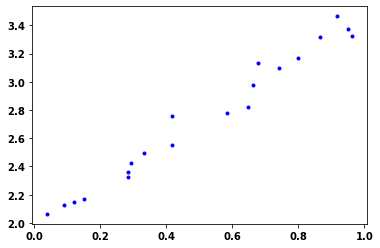

In [12]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1.5
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.');

In [14]:
# Trainable variables
w = tf.Variable(np.random.random(), trainable=True)
b = tf.Variable(np.random.random(), trainable=True)

# Loss function 
def simple_loss(real_y, pred_y):
    return tf.abs(real_y - pred_y)

LEARNING_RATE = 0.001

# Fit function
def fit_data(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Make prediction
        pred_y = w * real_x + b
        # Calculate the loss
        reg_loss = simple_loss(real_y, pred_y)
        
    # Calculate gradients
    w_gradient = tape.gradient(reg_loss, w)
    b_gradient = tape.gradient(reg_loss, b)
    
    # Update variables
    w.assign_sub(w_gradient * LEARNING_RATE)
    b.assign_sub(b_gradient * LEARNING_RATE)
    

In [15]:
# do the fitting
for _ in range(500):
    fit_data(x_train, y_train)

m:<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4711065>,  trained m:1.4711065292358398
b:<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9893987>,  trained b:1.989398717880249


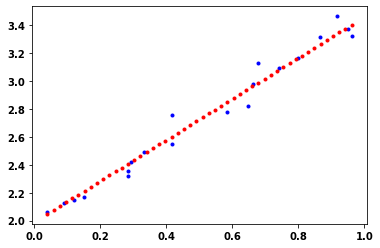

In [16]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(w, w.numpy()))
print("b:{},  trained b:{}".format(b, b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, w*x_linear_regression + b, 'r.');


## Simple example of using gradient tape to calculate gradient of a function

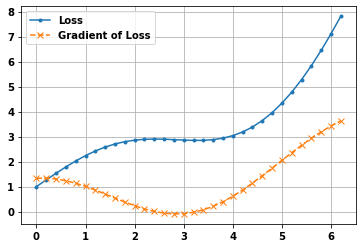

In [17]:
def myfunc(x):
    return tf.math.sin(x) + tf.math.exp(x/3)

w = tf.Variable(np.arange(0, np.pi*2,.2))
with tf.GradientTape() as tape:
    loss = myfunc(w)
gradient = tape.gradient(loss, w).numpy()

plt.plot(w.numpy(), loss,'.-')
plt.grid(True)
plt.plot(w.numpy(), gradient,'x--');
plt.legend(['Loss','Gradient of Loss']);

## Using watch

If use `watch` on a variable the following variables referencing that variable are also watched

But the calls to new functions need to be within the `with` statement, but the gradient getting doesn't

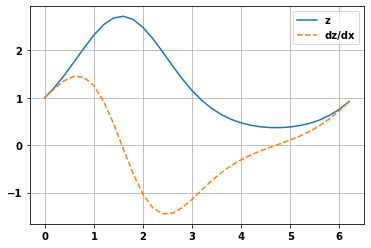

In [18]:
x = tf.Variable(np.arange(0, np.pi*2,.2))

with tf.GradientTape() as t:
    t.watch(x)
    
    y = tf.sin(x)
    z = tf.exp(y)
dz_dx = t.gradient(z,x)

plt.plot(x.numpy(),z.numpy())
plt.plot(x.numpy(),dz_dx.numpy(),'--')
plt.legend(['z','dz/dx'])
plt.grid(True)

# Multiple layer model Optimization

For multiple layers it is the same but we need to iterate over the layers too.

If we put the gradients part within it's own function, putting `@tf.function` before that unction to speed things up.

#### Get the data

In [19]:
import tensorflow_datasets as tfds
train_data = tfds.load('fashion_mnist',split='train')
test_data = tfds.load('fashion_mnist',split='test')


def format_image(data):
    image = data['image']
    image = tf.reshape(image,[-1])#flatten out
    image = tf.cast(image,'float32')/255.

    return image,data['label']

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

# starts with a buffer of the first 1024 examples from the training dataset and hold them in memory,
# and then randomly sample from that buffer
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size)


#### Define the loss function and optimizer and metrics


In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


#### Define the model


In [21]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='clothing')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

#### Create a validation loss function

In [23]:
def perform_validation():
    losses = []
    #run through the validation batches
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
    return losses

#### Define the function to do forward and backward passes

Update parameters with optimizer

`optimizer.apply_gradients(zip(grads, model.trainable_variables))`

Almost equivalent with what used before

`w.assign_sub(w_gradient * LEARNING_RATE)`

In [24]:
# Define a function to compute the forward and backward pass
@tf.function
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        # forward pass
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
    # backward pass
    gradients = tape.gradient(loss_value, model.trainable_variables)
    # update values
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return logits, loss_value

In [25]:
#hide
from tqdm import tqdm

In [26]:
def train_data_for_1_epoch():
    losses=[]
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
        
        train_acc_metric(y_batch_train, logits)
        
        pbar.set_description('Training loss for step %s: %.4f' % (int(step), float(loss_value)))
        pbar.update()
    return losses

#### Do the training

In [27]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical
import time

model = base_model()

start_time = time.time()

train_loss_results = []
val_loss_results =[]

train_acc_results = []
val_acc_results =[]

num_epochs=20

for epoch in range(num_epochs):
    
    # run through training batch
    losses_train = train_data_for_1_epoch()
    
    #calc validation
    losses_val = perform_validation()
    
    losses_train_mean = np.mean(losses_train) 
    losses_val_mean = np.mean(losses_val)
    
    train_loss_results.append(losses_train_mean)
    val_loss_results.append(losses_val_mean)
    
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

print("Duration :{:.3f}".format(time.time() - start_time))

Training loss for step 937: 0.3226: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.5714: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.4961: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.4239: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.0952: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1274: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2766: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1167: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1965: 100%

Duration :145.818


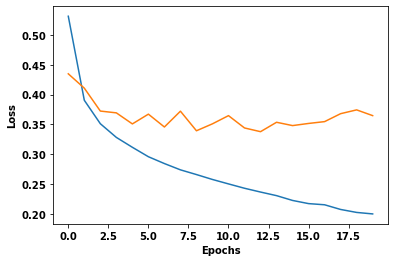

In [28]:
plt.plot(train_loss_results)
plt.plot(val_loss_results)
plt.ylabel('Loss')
plt.xlabel('Epochs');

# Graph based models


Eager mode can make it easier for you to write code that gives immediate results.
But TensorFlow was originally designed for programming being done in graph mode, where you had to define a graph with all of your operations before you executed it. This adds more performance.

In tensorflow the AutoGraph technology is the part that makes graph-based code a little easier.

- Parallelism / Distribute on different machines
- Compilation
- Different coding required 
    - if statements replaced with tf.cond and def statements
- Maybe switch to graph mode after eager mode when moving to production

Add `@tf.function` above the function to utilise graph mode. 
- Will also convert functions called within that function.
- It means don't have to convert code to form useable for graph mode.
- The most improvement is on functions with more operations.
- Make sure order of execution is what is intended.
- Print not designed to work with graph mode for multiple calls in a loop.
- Declare variables outside functions.


In [29]:
@tf.function
def multiply(a,b):
    return a*b
a=tf.Variable(np.arange(0,10,1))
b=a-1

print(tf.multiply(a,b))
print("\nThe converted code:\n")

print(tf.autograph.to_code(multiply.python_function))


tf.Tensor([ 0  0  2  6 12 20 30 42 56 72], shape=(10,), dtype=int32)

The converted code:

def tf__multiply(a, b):
    with ag__.FunctionScope('multiply', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = (ag__.ld(a) * ag__.ld(b))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [30]:
#collapse-output
@tf.function
def fizzbuzz():
    for i in range(1,100):
        if i%3==0 and i%5==0:
            print(i,'FizzBuzz')
        elif i%3==0:
            print(i,'Fizz')
        elif i%5==0:
            print(i,'Buzz')
print(tf.autograph.to_code(fizzbuzz.python_function))

def tf__fizzbuzz():
    with ag__.FunctionScope('fizzbuzz', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:

        def get_state_3():
            return ()

        def set_state_3(block_vars):
            pass

        def loop_body(itr):
            i = itr

            def get_state_2():
                return ()

            def set_state_2(block_vars):
                pass

            def if_body_2():
                ag__.ld(print)(ag__.ld(i), 'FizzBuzz')

            def else_body_2():

                def get_state_1():
                    return ()

                def set_state_1(block_vars):
                    pass

                def if_body_1():
                    ag__.ld(print)(ag__.ld(i), 'Fizz')

                def else_body_1():

                    def get_state():
                        return ()

                    def set_state(block_vars):
                        pass
